## Notebook that trains a regular GAN to generate positions of galaxies in images

Implementation adapted from: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
and
https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/dcgan/dcgan.py

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.utils import save_image
import torchvision
from PIL import Image
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML
import pickle

# set up accordingly
data_dir = "../../data"        # directory with data files
labeled_data = "labeled_info.pkl"        # file within data directory with labeled images' galaxy centers (0, 1)
scored_data = "scored_info.pkl"             # file within data directory with scored images' galaxy centers
scores = "scored.csv"                       # file within data directory with scored images' scores
device = torch.device("cuda")               # cuda or cpu
collab = False                               # google collab flag

In [3]:
# google collab
# mount drive, copy over data as zip and unzip it
if collab:
  from google.colab import drive
  drive.mount('/content/drive')
  collab_dir = "/content"

In [2]:
class GalaxyCentersDataset(torch.utils.data.Dataset):
    """
    Galaxy centers dataset class
    Builds a dataset with images representing where galaxies are located. 
    Images are divided into a grid, squares are 1 if there is a galaxy center there, 0 otherwise.
    """

    def __init__(self, labeled_data, scored_data=None, scores_file=None, train=True, patch_size=(64, 64), train_split=0.8, scored_threshold=2):
        with open(os.path.join(labeled_data), 'rb') as pickle_file:
          labeled_data = pickle.load(pickle_file)
        self.centers = {}
        for id in labeled_data.keys():
          self.centers[id] = labeled_data[id]['cluster_centers']
        if scored_data is not None and scores_file is not None:
            with open(os.path.join(scored_data), 'rb') as pickle_file:
              scored_data = pickle.load(pickle_file)
            scores = pd.read_csv(scores_file, index_col="Id")
            valid = scores.index[scores['Actual'] >= scored_threshold].astype(str)
            for id in valid:
              self.centers[id] = scored_data[id]['cluster_centers']
        
        self.centers = list(self.centers.values())
        if train == False:
          self.centers = self.centers[int(len(self.centers)*train_split):]
        else:
          self.centers = self.centers[:int(len(self.centers)*train_split)]
          
        
        self.samples = []
        self.patch_size = patch_size
        
        self.load_dataset()
    def __len__(self):
        return len(self.samples)

    def load_dataset(self):
      print("Loading Dataset...")
      buckets_y = [i*self.patch_size[0] for i in range (1024//self.patch_size[0])]
      buckets_x = [i*self.patch_size[1] for i in range (1024//self.patch_size[1])]
      for image in self.centers:
        im = np.ones((1, 1024//self.patch_size[0], 1024//self.patch_size[1]), dtype=float) * -1
        for center in image:
          y = np.digitize(center[0], buckets_y) - 1
          x = np.digitize(center[1], buckets_x) - 1
          im[:, y, x] = 1
        self.samples.append(torch.Tensor(im))
      print("Dataset Loaded")

    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.samples[idx]

        return image

In [6]:
batch_size = 64
size = (32, 32)
latent_dim = 16

train_dataset = GalaxyCentersDataset(os.path.join(data_dir, labeled_data), scored_data=os.path.join(data_dir, scored_data), scores_file=os.path.join(data_dir, scores), train=True, patch_size=size, train_split=1.0, scored_threshold=2)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=1, pin_memory=True)
print("{} images loaded".format(len(train_dataset)))

Loading Dataset...
Dataset Loaded
3967 images loaded


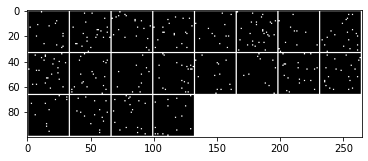

In [5]:
plt.imshow(np.transpose(vutils.make_grid(torch.stack(train_dataset[0:20]), padding=1, pad_value=1, normalize=True, range=(-1, 1)), (1, 2, 0)))

In [0]:
gen_base_filters = 8
disc_base_filters = 8

# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [0]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            # latent_dim x 1 x 1
            nn.ConvTranspose2d( latent_dim, gen_base_filters * 8, 4, 1, 0, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(gen_base_filters * 8),
            # state size. (gen_base_filters*8) x 4 x 4
            nn.ConvTranspose2d(gen_base_filters * 8, gen_base_filters * 4, 4, 2, 1, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(gen_base_filters * 4),
            # state size. (gen_base_filters*4) x 8 x 8
            nn.ConvTranspose2d(gen_base_filters * 4, gen_base_filters * 2, 4, 2, 1, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(gen_base_filters * 2),
            # state size. (gen_base_filters*4) x 16 x 16
            nn.ConvTranspose2d( gen_base_filters * 2, 1, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. 1 x 32 x 32
        )

    def forward(self, input):
        return self.main(input)

In [17]:
gen = Generator().to(device)
gen.apply(weights_init)
print(gen)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(16, 64, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): ReLU(inplace=True)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): ReLU(inplace=True)
    (8): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ConvTranspose2d(16, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)


In [0]:
class Discriminator(nn.Module):
    def __init__(self, noise=False):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is 1 x 32 x 32
            nn.Conv2d(1, disc_base_filters * 2, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (disc_base_filters * 2) x 16 x 16
            nn.Conv2d(disc_base_filters * 2, disc_base_filters * 4, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(disc_base_filters * 4),
            # state size. (disc_base_filters*4) x 8 x 8
            nn.Conv2d(disc_base_filters * 4, disc_base_filters * 8, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(disc_base_filters * 8),
            # state size. (disc_base_filters*8) x 4 x 4
            nn.Conv2d(disc_base_filters * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            # state size. 1 x 1 x 1
        )
        self.noise=noise

    def forward(self, input, sigma=0.2):
        if self.noise:
          # try adding random noise: mean 0, 
          input = input + torch.randn(*input.shape, device=device)*sigma
        return self.main(input)

In [19]:
disc = Discriminator().to(device)
disc.apply(weights_init)
print(disc)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(64, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)


Set up training parameters

In [0]:
G_losses = []
D_losses = []
img_list = []

# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 0.9
fake_label = 0
gen_lr = 1e-4
disc_lr = 2e-4
epochs = 500
# generator takes this many steps for every 1 of the discriminator
gen_steps = 1
# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(disc.parameters(), lr=disc_lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(gen.parameters(), lr=gen_lr, betas=(0.5, 0.999))

Function that takes one GAN step

In [0]:
def gan_step(batch_num, batch, disc, gen):
  ############################
  # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
  ###########################
  ## Train with all-real batch
  disc.zero_grad()
  # Format batch
  real_cpu = data.to(device)
  b_size = real_cpu.size(0)
  label = torch.full((b_size,), real_label, device=device)
  # Forward pass real batch through D
  output = disc(real_cpu).view(-1)
  # Calculate loss on all-real batch
  errD_real = criterion(output, label)
  # Calculate gradients for D in backward pass
  errD_real.backward()
  D_x = output.mean().item()

  ## Train with all-fake batch
  # Generate batch of latent vectors
  noise = torch.randn(b_size, latent_dim, 1, 1, device=device)
  # Generate fake image batch with G
  fake = gen(noise)
  label.fill_(fake_label)
  # Classify all fake batch with D
  output = disc(fake.detach()).view(-1)
  # Calculate D's loss on the all-fake batch
  errD_fake = criterion(output, label)
  # Calculate the gradients for this batch
  errD_fake.backward()
  D_G_z1 = output.mean().item()
  # Add the gradients from the all-real and all-fake batches
  errD = errD_real + errD_fake
  

  ############################
  # (2) Update G network: maximize log(D(G(z)))
  # try training discriminator more than generator
  ###########################
  for _ in range (gen_steps):
    fake = gen(noise)
    gen.zero_grad()
    label.fill_(real_label)  # fake labels are real for generator cost
    # Since we just updated D, perform another forward pass of all-fake batch through D
    output = disc(fake).view(-1)
    # Calculate G's loss based on this output
    errG = criterion(output, label)
    # Calculate gradients for G
    errG.backward()
    D_G_z2 = output.mean().item()

  # Output training stats
  if i % 5 == 0:
      print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
            % (epoch, epochs, i, len(train_loader),
                errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
  return errD, errG

Begin training and periodically save generator output

In [22]:
results_dir = "results_position_gan_32_5"
if not os.path.exists(results_dir):
  os.mkdir(results_dir)
  os.mkdir(os.path.join(results_dir, "network_output"))
  os.mkdir(os.path.join(results_dir, "final_output"))
for epoch in range(1, epochs + 1):
    # For each batch in the dataloader
    for i, data in enumerate(train_loader, 0):

        errD, errG = gan_step(i, data, disc, gen)
        
        # Update G
        optimizerG.step()
        # Update D
        optimizerD.step()
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (epoch % 5 == 0 and i == len(train_loader)-1):
            with torch.no_grad():
                fake = gen(fixed_noise).detach().cpu()
            final = torch.clone(fake)
            final[final <= 0] = -1
            final[final > 0] = 1
            img_list.append(vutils.make_grid(final, padding=1, pad_value=1, normalize=True, range=(-1, 1)))
            vutils.save_image(fake, os.path.join(outf, results_dir, "network_output") + "/epoch" + str(epoch) + ".png", padding=1, pad_value=1, normalize=True, range=(-1, 1))
            vutils.save_image(final, os.path.join(outf, results_dir, "final_output") + "/epoch" + str(epoch) + ".png", padding=1, pad_value=1, normalize=True, range=(-1, 1))

Streaming output truncated to the last 5000 lines.
[116/500][30/62]	Loss_D: 0.8379	Loss_G: 0.8892	D(x): 0.8666	D(G(z)): 0.3949 / 0.3949
[116/500][35/62]	Loss_D: 0.9672	Loss_G: 0.7480	D(x): 0.8783	D(G(z)): 0.4688 / 0.4688
[116/500][40/62]	Loss_D: 1.0872	Loss_G: 0.6510	D(x): 0.9204	D(G(z)): 0.5287 / 0.5287
[116/500][45/62]	Loss_D: 1.0213	Loss_G: 0.7001	D(x): 0.8994	D(G(z)): 0.4976 / 0.4976
[116/500][50/62]	Loss_D: 0.8416	Loss_G: 0.8836	D(x): 0.8783	D(G(z)): 0.3977 / 0.3977
[116/500][55/62]	Loss_D: 0.9103	Loss_G: 0.8044	D(x): 0.8767	D(G(z)): 0.4379 / 0.4379
[116/500][60/62]	Loss_D: 0.9394	Loss_G: 0.7736	D(x): 0.8839	D(G(z)): 0.4547 / 0.4547
[117/500][0/62]	Loss_D: 1.0757	Loss_G: 0.6618	D(x): 0.9269	D(G(z)): 0.5218 / 0.5218
[117/500][5/62]	Loss_D: 1.0706	Loss_G: 0.6620	D(x): 0.9143	D(G(z)): 0.5213 / 0.5213
[117/500][10/62]	Loss_D: 0.9020	Loss_G: 0.8110	D(x): 0.8864	D(G(z)): 0.4344 / 0.4344
[117/500][15/62]	Loss_D: 0.9653	Loss_G: 0.7458	D(x): 0.8898	D(G(z)): 0.4697 / 0.4697
[117/500][20/62]

In [0]:
torch.save(gen.state_dict(), os.path.join(outf, results_dir, "gen.model"))
torch.save(disc.state_dict(), os.path.join(outf, results_dir, "disc.model"))
if collab:
  !cp -rf '{results_dir}' '{data_dir}'
  !cp '{results_dir}'/gen.model '{data_dir}'/'{results_dir}'
  !cp '{results_dir}'/disc.model '{data_dir}'/'{results_dir}'

Plot training loss

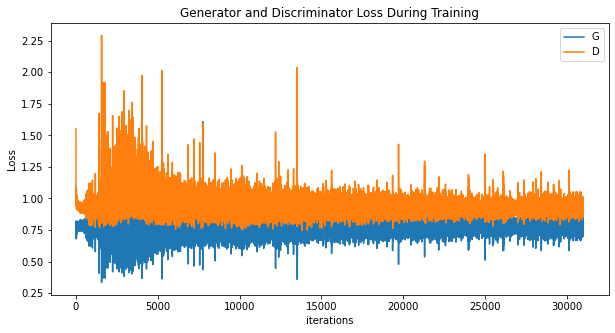

In [24]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Check how images progressed

In [0]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [0]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=2, metadata=dict(artist='Me'), bitrate=1000)
ani.save("epochs_position_gan.mp4", writer=writer)